In [37]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
#the Notebook only uses the given dataframes, during the task a few others dataframes are created
df_sent_original = pd.read_csv("Offers_sent.csv")
df_accepted_original = pd.read_csv("Offers_accepted.csv")

In [3]:
# we merge df_accepted_original and df_sent_original on the ApplianceID to obtain a datframe with all neccessary information to solve task a (know to 
# which brand each accepted over belongs belong) First I thought we need to merge on both ApplianceID and CustomerID, but the ApplianceID is unique. Using both keys does not change the result 
 
df_accepted = pd.merge(df_accepted_original, df_sent_original, left_on="ApplianceID", right_on="ApplianceID")
#df_accepted = pd.merge(df_accepted_original, df_sent_original, left_on=["CustomerID", "ApplianceID"], right_on=["CustomerID", "ApplianceID"])

In [7]:
# Task a
#The conversion rate is defined as the number of offers accepted divided by the number of
#offers sent. Calculate the conversion rate for each brand and assess whether there is a
#statistically significant difference between them.

# to solve task we create a loop over all given brands [A,B,C], then we filter in df_sent_original for all rows belonging to this brand and count the number
# of rows using shape[0], we store this in the element sent. Similar we can find out the number of accepted offers, stored in the element accepted. We can
# calculate the conversion rate as accepted/sent for a given brand. All 3 conversion rates are stored in the element conversion rates
conversion_rates=[]
for i in df_sent_original.Brand.unique():
    sent = df_sent_original[df_sent_original.Brand==i].shape[0]
    accepted = df_accepted[df_accepted.Brand==i].shape[0]
    
    conversion_rate = accepted/sent
    
    conversion_rates.append([i,conversion_rate])

print(conversion_rates)
#Answer: The given matrix shows the conversion rate for each brand
#[['A', 0.020012442969722107],
# ['C', 0.015873015873015872],
# ['B', 0.017894736842105262]]
# The second part of the question proposes that if there is statistical significant difference to the conversion rate. The highest conversion rate can be found
# for brand A around 2%, while the second highest is brand B with 1,78% and the lowest of brand C with 1,58%. Looking at the percentage numbers the difference in
# conversion numbers seems pretty small, with the difference in conversion rate from highest to lowest being 0,42% percent. I think to make a reasonable decision,
# if selling/advertising one brand more we further need to know how much money/revenue an average insurance contract brings per brand. So if a Contract of brand 
# policy A brings on average a 1000 and for brand C 10000 Pounds, C is definitely a better brand to sell.
# Concerning statistical significance (I am not sure if this requires a statiscal analysis) we could further calculate mean and variance. And create a distribution
# for the given data points. Here it has to be said that 3 data points are not enough to make these measures meaningful. The normal distribution thus could show how
# likely each of the conversion rates is to be seen given previous data.



In [17]:
# Task b
#Graphically present how the total acceptance of offers develops over time, i.e. how many
#offers have been accepted after a specified time from being sent (daily or weekly graph).

# I used the python datetime model to create timestamps from the given sent and accepted date, again I used the previously merged dataframe df_accepted.
# We loop over each row (each of the 290 accepted offers), create the timestamps for sent and accepted these are stored in the elements sent_date & accept_date
# we can then calculate the difference of both timestamps stored in time_delta. All 290 time_deltas are stored in the list time_deltas, which we then make a column
# in the dataframe df_accepted. Afterwards, we use this timestamp for example showing 7 days to create a column of integers meaning the column now shows 7 (for days) or 1 (for weeks),
# note that weeks are rounded. Thus one offer was accepted after 0 weeks, meaning the offer was accepted in less than 3.5 days. Last before plotting our data 
# as bar charts we create 2 new dataframes, where we count how often a over was accepted in x days/weeks.
time_deltas = []
for i in df_accepted.index:
    sent_date = datetime.datetime.strptime(df_accepted[df_accepted.index==i].OfferContactDate.values[0], '%d/%m/%Y')
    accept_date = datetime.datetime.strptime(df_accepted[df_accepted.index==i].OfferAcceptanceDate.values[0], '%d/%m/%Y')
    time_delta = accept_date - sent_date
    time_deltas.append(time_delta)

df_accepted["time_deltas"] = time_deltas
df_accepted['time_deltas_days'] = df_accepted.time_deltas.apply(lambda x: x.days)
df_accepted["time_deltas_weeks"] = df_accepted.time_deltas_days.apply(lambda x: int(round(x/7,0)))

df_counts_days = pd.DataFrame(df_accepted["time_deltas_days"].value_counts()).reset_index().sort_values("index")
df_counts_days = df_counts_days.rename(columns={"index": "day", "time_deltas_days":"occurences"})
df_counts_weeks = pd.DataFrame(df_accepted["time_deltas_weeks"].value_counts()).reset_index().sort_values("index")
df_counts_weeks = df_counts_weeks.rename(columns={"index": "week", "time_deltas_weeks":"occurences"})

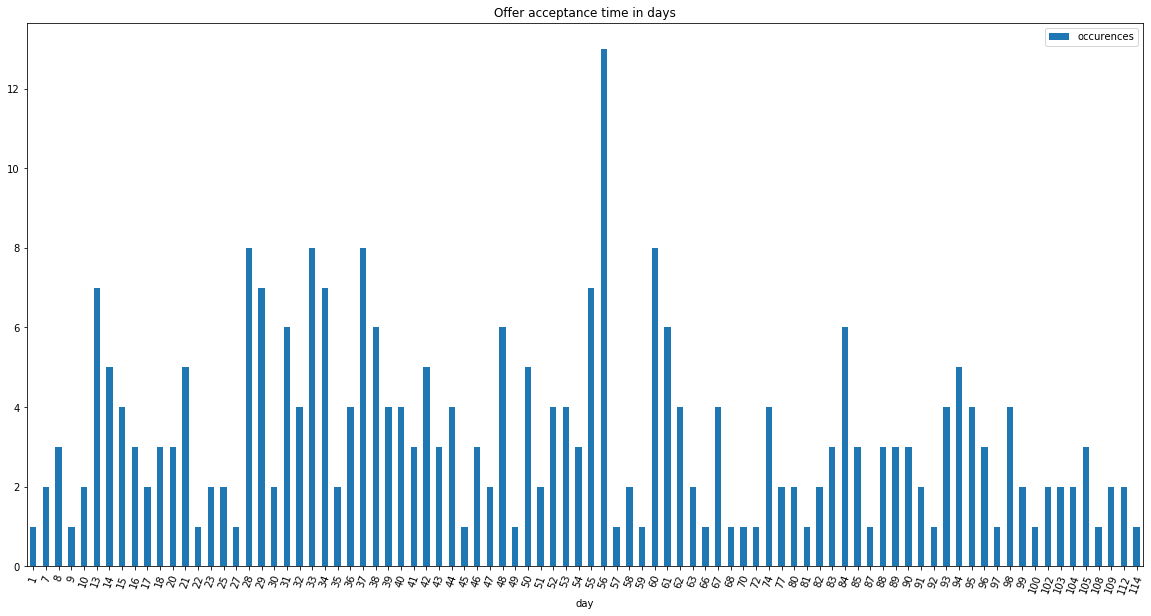

In [71]:
# this cell creates a bar plot showing how often an offer was accepted after x days
df_counts_days.plot.bar(x="day", y="occurences", rot=70, title="Offer acceptance time in days" , figsize=(20,10))
plt.savefig('count_days.png')

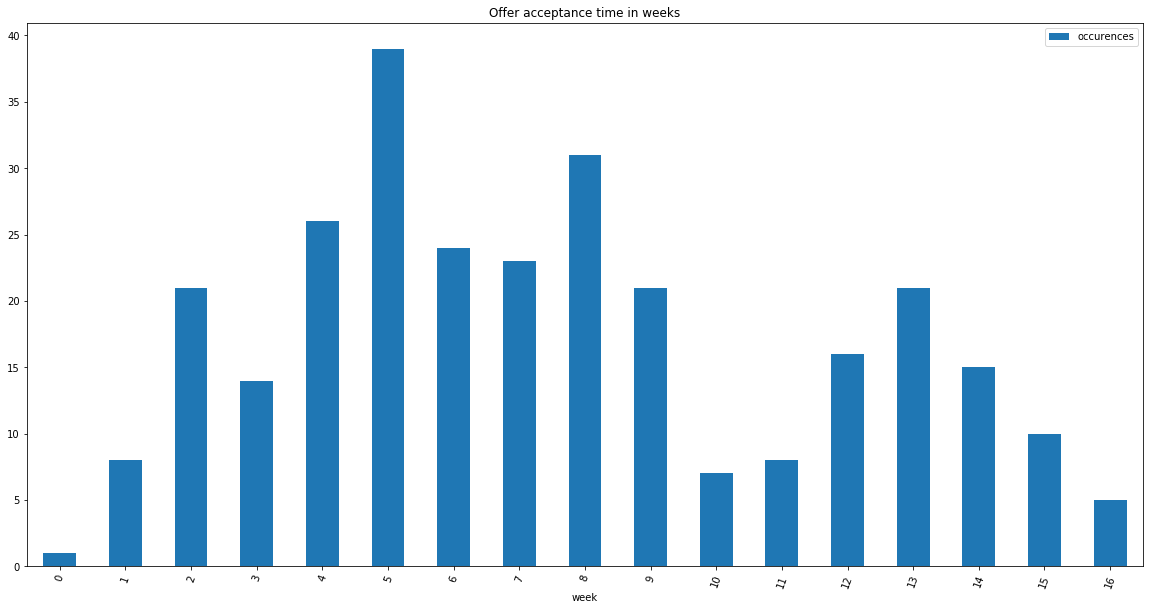

In [72]:
# this cell creates a bar plot showing how often an offer was accepted after x weeks
df_counts_weeks.plot.bar(x="week", y="occurences", rot=70, title="Offer acceptance time in weeks", figsize=(20,10))
plt.savefig('count_weeks.png')

In [31]:
# task c1 
# Using any technique, build a predictive model to predict whether an offer will be accepted
# using columns V1-V9. Briefly explain your choice of model, and decide which variables are
# most important in the model. Furthermore, examine the model and report on an accuracy
# metric(s) of your choice. Please do not spend too much time optimising model parameters.

# NOTE due to the unbalance in the data the classifier will predict all data points as 0 (offer not accepted), this yielsds an accuracy of 0.9826.
# Therefore, I first trained the classifier on the whole data, where alll points will be predicted as 0 (task c1) and then on a more balanced dataset (task c2)
# This did change my results significantly, if we choose an equal rate 290 offers rejected and 290 accepted the classifier has a slightly accuracy than
# guessing (0.5833). If we look at the confusion matrices both models do not score well.
# I also tried different algorithms like logistic regression and support vector machines, none of them showed a significant higher accuracy.
# I will now answer the general questions and then explain both experiments:


# Briefly explain your choice of model? 
# I choose the random forest model, because it is intuitive to explain to an audience, like higher management. Moreover,
# the Random Forest can be interpreted quite well. It can be seen how each tree in the forest is constructed and why this is the case. Further, the Gini-Coefficient
# as an impurity measure can be used to observe, which variable is most important for a prediction.

# Decide which variables are most important in the model?
# The feature importance for the whole data set shows:
# [0.1580065  0.06341659 0.08218908 0.08344942 0.08000076 0.20733336 0.         0.20604801 0.11955628]
# This indicates that the variables V6, V8 and V1  are most important
# The feature importance for the 50/50 data set shows:
# [0.06075827 0.00655047 0.03724665 0.16381524 0.03999418 0.55570117 0.         0.06343682 0.07249721]
# This indicates that the variables V6, V4 and V9 are most important
# Moreover, as also shown in task d, variable V7 has no value for the model and we can leave this feature out while predicting. Note, I tried different combinations
# of features, none for modelling, none of them increased the accuarcy significantly

#Furthermore, examine the model and report on an accuracy metric(s) of your choice. 
# This is shown in the given code


# The folllowing code first creates the neccessary data for prediction, for both of my experiments
# we merge the dt_sent_original with df_accepted_original and use the full outer join. This means that all rowd of both dataframes will be kept.
# If there is no information for a given row the NAN will be shown for a given column 
df_prediction = pd.merge(df_sent_original, df_accepted_original, left_on=["ApplianceID"], right_on=["ApplianceID"], how="outer")
df_prediction.OfferAcceptanceDate = df_prediction.OfferAcceptanceDate.replace(np.nan, 0) # we replace NAN with 0 

# this function is defined so we can create a new class column which returns 0 if 0 is shown and 1 else. This inditifies the columns, which have been accepted
# and labels them as 1
def create_class(class_info):
    if class_info == 0:
        return 0
    else:
        return 1

df_prediction["offer_accepted"] = df_prediction.OfferAcceptanceDate.apply(lambda x: create_class(x)) #use the predefined function

df_prediction = df_prediction[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'offer_accepted']] #we just use the columns which are meant for prediction + class

# the algorithm only accepts numerical values, thus we have to encode our string columns
df_prediction["V1"] = pd.factorize(df_prediction["V1"])[0]
df_prediction["V2"] = pd.factorize(df_prediction["V2"])[0]
df_prediction["V3"] = pd.factorize(df_prediction["V3"])[0]
df_prediction["V7"] = pd.factorize(df_prediction["V7"])[0]

df_prediction_small = df_prediction[df_prediction.offer_accepted==0][:290].append(df_prediction[df_prediction.offer_accepted==1]) #creates a subset of the original data which uses 50/50 rate of accepted and declined

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.1580065  0.06341659 0.08218908 0.08344942 0.08000076 0.20733336
 0.         0.20604801 0.11955628]
0.9826171875
[[5031    0]
 [  89    0]]


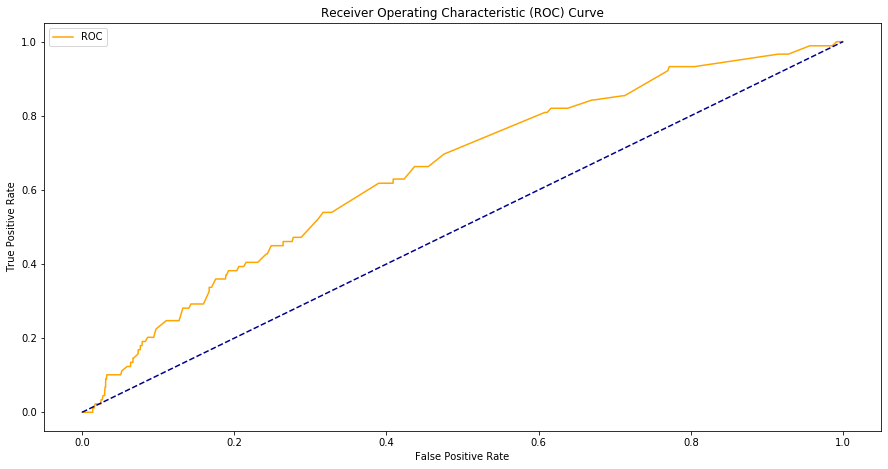

In [68]:
# Modelling for the full data set 
y = df_prediction.offer_accepted.values
X = df_prediction[["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) #train-test split
clf = RandomForestClassifier(max_depth=2, random_state=0) #create model no paramtertuning was used
clf.fit(X_train, y_train) #fit model on training data
print(clf.feature_importances_) #get feature importance
y_test_hat = clf.predict(X_test) #predict classes for test set
print(accuracy_score(y_test, y_test_hat)) #print accuarcy print confusion metrices Answer: 0.9826
print(confusion_matrix(y_test, y_test_hat)) #print confusion matrix

#create ROC-curve
fig = plt.figure(figsize=(15,7.5))
probs = clf.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs)
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.06075827 0.00655047 0.03724665 0.16381524 0.03999418 0.55570117
 0.         0.06343682 0.07249721]
0.5833333333333334
[[53 37]
 [43 59]]


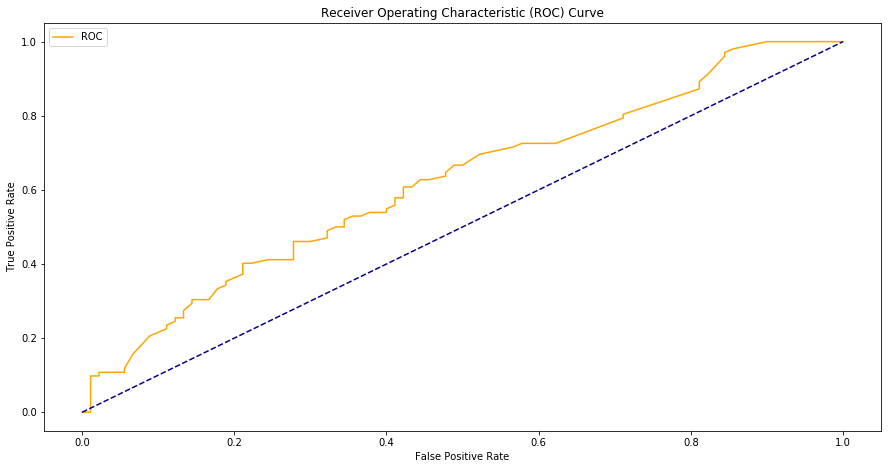

In [69]:
# Modell for balanced data setb
y = df_prediction_small.offer_accepted.values
X = df_prediction_small[["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) #train-test split
clf = RandomForestClassifier(max_depth=2, random_state=0) #create model no paramtertuning was used
clf.fit(X_train, y_train) #fit model on training data
print(clf.feature_importances_) #get feature importance
y_test_hat = clf.predict(X_test) #predict classes for test set
print(accuracy_score(y_test, y_test_hat)) #print accuarcy print confusion metrices
print(confusion_matrix(y_test, y_test_hat)) #print confusion matrix

#create ROC-curve
fig = plt.figure(figsize=(15, 7.5))
probs = clf.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs)
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# task d
# V7 is the treatment category and currently, the business only applies treatment A. The
# business has decided to introduce new treatment categorical values to V7, factors B, C, and
# D. Design an experiment to assess the potential impact of the new factors on conversion
# rates and include which statistical methods you would use. Please state any assumptions
# made. (R is not required here, you can answer this question in comments)

#I would try design an experiment using the average treatment effect (ATE). 
#The ATE is defined as:
#    ATE=1/N SUM over i till N(y_1(i)-y_0(i))
#The measure is similar to the mean squared error. N is the number of total samples.
#We create a sum over all samples (i) here y_1(i) is the ouctome given a Treatment A, B, C, D. This could for example be 1 or 0 meaning an offer was excepted or declined. 
#Moreover, it could be a number like 100000 indicating the price of the insurance given a treatment. y_0(i) describes a similar outcome as y_1(i), without a treatment.
#Note we could also design the experiment so that y_0(i) is the the ouctome of treatment A and y_1(i) describes the outcome of using treatment B,C,D.
#
#If we calculated ATE we can then interpret the value:
#    If ATE=0 the treatment does not have an effect.
#    If ATE<0 means the treatment has worse effect on the ouctome than the prior solution
#    If ATE>0 the treatment has a better effect on the outcome than the prior solution
#    
#We now want to pick the treatment with the highest ATE. As it gives us either the most accepted contracts or the most revenue per contract. Again we should also look 
#at the cost of each treatment in a real world case.